Loan Prediction using decision trees from Spark's mllib library. 
Datasets for training and test from [here](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/) 
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.

In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

Description of data

Loan_ID          :   Unique Loan ID

Gender           :   Male/ Female 

Married          :   Applicant married (Y/N)

Dependents       :   Number of dependents

Education        :   Applicant Education (Graduate/ Under Graduate)

Self_Employed    :   Self employed (Y/N)

ApplicantIncome  :   Applicant income

CoapplicantIncome:  Coapplicant income

LoanAmount       :   Loan amount in thousands

Loan_Amount_Term :   Term of loan in months

Credit_History   :    credit history meets guidelines

Property_Area    :Urban/ Semi Urban/ Rural

Loan_Status :Loan approved (Y/N)

In [2]:
#Reading training and test data
train=pd.read_csv('train_u6lujuX_CVtuZ9i.csv')
train.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Cleanup of data

In [3]:
def conv(x):
    d=dict(x.value_counts())
    maximum=max(d,key=d.get)
    x.fillna(maximum)
    val=int(len(list(x.value_counts())))
    name=list(x.unique())
    mapped=dict(zip(name, range(val)))
    print(mapped)
    x.replace(mapped, inplace=True)
    
#function to convert all missing values in a column to the most frequent value and to convert string categorical values
#to numeric values

In [4]:
print("For training set")
conv(train['Gender'])
conv(train['Married'])
conv(train['Education'])
conv(train['Self_Employed'])
conv(train['Property_Area'])
conv(train['Loan_Status'])



For training set
{'Male': 0, 'Female': 1}
{'No': 0, 'Yes': 1}
{'Graduate': 0, 'Not Graduate': 1}
{'No': 0, 'Yes': 1}
{'Urban': 0, 'Rural': 1, 'Semiurban': 2}
{'Y': 0, 'N': 1}


In [5]:
train.head()
#After conversion

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0.0,0.0,0,0,0.0,5849,0.0,NaN,360.0,1.0,0,0
1,LP001003,0.0,1.0,1,0,0.0,4583,1508.0,128.0,360.0,1.0,1,1
2,LP001005,0.0,1.0,0,0,1.0,3000,0.0,66.0,360.0,1.0,0,0
3,LP001006,0.0,1.0,0,1,0.0,2583,2358.0,120.0,360.0,1.0,0,0
4,LP001008,0.0,0.0,0,0,0.0,6000,0.0,141.0,360.0,1.0,0,0


In [6]:
#Fill all missing values in numeric columns with frequently occuring value
train.Loan_Amount_Term.fillna(360.0, inplace=True)
train.Credit_History.fillna(1.0, inplace=True)
train.CoapplicantIncome.replace(0.0, np.NaN, inplace=True)
train.LoanAmount.replace(0.0, np.NaN, inplace=True)

#Convet string value to numeric
train.Dependents.replace("3+", 3, inplace=True)

#Replace missing values with mean of all other values
coappmean=int(train.CoapplicantIncome.mean())
loanamt= int(train.LoanAmount.mean())
train.CoapplicantIncome.fillna(coappmean, inplace=True)
train.LoanAmount.fillna(loanamt, inplace=True)

#index is not a useful parameter for classification
train.drop(['Loan_ID'],axis=1, inplace=True)




In [7]:
train=train.dropna()

#Drop all rows that contain missing values even after clean up

In [8]:
train.to_csv("train_loan.csv", header=False, index=False)
train=open("train_loan.csv", "r")
train=[line.rstrip('\n') for line in train]

train[:5]

['0.0,0.0,0,0,0.0,5849,2919.0,146.0,360.0,1.0,0,0',
 '0.0,1.0,1,0,0.0,4583,1508.0,128.0,360.0,1.0,1,1',
 '0.0,1.0,0,0,1.0,3000,2919.0,66.0,360.0,1.0,0,0',
 '0.0,1.0,0,1,0.0,2583,2358.0,120.0,360.0,1.0,0,0',
 '0.0,0.0,0,0,0.0,6000,2919.0,141.0,360.0,1.0,0,0']

Modeling decision tree and predicting values for test set

In [9]:
#Create Spark Context

sc=pyspark.SparkContext()
from pyspark.mllib.regression import LabeledPoint


In [10]:


#Create RDD (Resilient Distributed Dataset) for train and test data 
#Split the csv and create labelled points with label as the value to be predicted (Loan status) for training data

train_rdd=sc.parallelize(train)
print(train_rdd.count())
(trainData, testData) = train_rdd.randomSplit([0.7, 0.3])
labeled_points_rdd = trainData.map(lambda row: row.split(',')).map(lambda seq: LabeledPoint(seq[-1],seq[:-2])) 
test_rdd= testData.map(lambda line: [float(i) for i in line.split(",")]).map(lambda seq: LabeledPoint(seq[-1],seq[:-2]))
print("%d and %d" %(labeled_points_rdd.count(),test_rdd.count()))



554
390 and 164


In [11]:
#using Decision Tree from pyspark mllib library 
from pyspark.mllib.tree import DecisionTree

#inputs - training data, num of classes to be predicted - 2, gini impurity is used
model = DecisionTree.trainClassifier(labeled_points_rdd, numClasses=2, categoricalFeaturesInfo={}, impurity='gini')

In [12]:
predictions = model.predict(test_rdd.map(lambda x: x.features))
labelsAndPredictions = test_rdd.map(lambda lp: lp.label).zip(predictions)
#Predictions are made on the test data

In [13]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(labelsAndPredictions)
print("Area under PR = %s" % metrics.areaUnderROC)


Area under PR = 0.7694029850746269


In [14]:
numofyandno=pd.Series([x for x in labelsAndPredictions.collect()])
print("Confusion matrix ")
print(numofyandno.value_counts())
count=list(numofyandno.value_counts())

print("\nAccuracy: %f" %(((count[0]+count[2])/sum(count))*100))


Confusion matrix 
(0.0, 0.0)    99
(1.0, 0.0)    35
(1.0, 1.0)    24
(0.0, 1.0)     6
dtype: int64

Accuracy: 75.000000


([<matplotlib.patches.Wedge at 0x7ff43ca97358>,
 [Text(-0.35192,1.04219,'True Yes'),
  Text(-0.271109,-1.06607,'False Yes'),
  Text(0.848638,-0.699867,'True No'),
  Text(1.09274,-0.126152,'False No')])

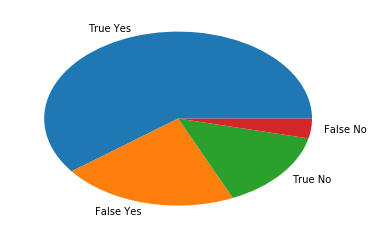

In [15]:
plt.pie(numofyandno.value_counts(), labels=['True Yes', 'False Yes', 'True No', 'False No'])
#Predicted Yes and No for test set